<a href="https://colab.research.google.com/github/young5057/HR_model/blob/main/Mymodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##### this file is to change the origianl resize.py, so that we can change the size with different input channels done1124
##### Given groups=1, weight of size 32 1 3 3, expected input[1, 3, 48, 29] to have 1 channels, but got 3 channels instead

In [1]:
#re
#!git clone https://github.com/dvschultz/SinGAN

Cloning into 'SinGAN'...
remote: Enumerating objects: 875, done.
remote: Total 875 (delta 0), reused 0 (delta 0), pack-reused 875
Receiving objects: 100% (875/875), 94.90 MiB | 13.26 MiB/s, done.
Resolving deltas: 100% (367/367), done.


In [3]:
#re
#!pip install torch==1.4.0 torchvision==0.5.0
%cd /content/SinGAN/

/content/SinGAN


In [4]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-3c161885-65b4-a783-5b78-bde30fceaf66)


In [6]:
from config import get_arguments
import SinGAN.functions as functions
import sys
import os
import SinGAN.models as models
import os
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import math
import matplotlib.pyplot as plt
from SinGAN.imresize import imresize
from config import get_arguments
from SinGAN.manipulate import *
from SinGAN.training import *
from SinGAN.imresize import imresize
import SinGAN.functions as functions
from __future__ import print_function
import SinGAN.functions
import SinGAN.models
import argparse
import os
import random
from SinGAN.imresize import *
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from skimage import io as img
from PIL import Image
import numpy as np
from skimage import color
import math
import imageio
import matplotlib.pyplot as plt
from SinGAN.training import *
from config import get_arguments

In [7]:
import numpy as np
from scipy.ndimage import filters, measurements, interpolation
from skimage import color
from math import pi
#from SinGAN.functions import torch2uint8, np2torch
import torch
def madjust_scales2image_SR(real_,maxs,opt):
    opt.min_size = 18
    opt.num_scales = int((math.log(opt.min_size / min(real_.shape[2], real_.shape[3]), opt.scale_factor_init))) + 1
    scale2stop = int(math.log(min(opt.max_size , max(real_.shape[2], real_.shape[3])) / max(real_.shape[0], real_.shape[3]), opt.scale_factor_init))
    opt.stop_scale = opt.num_scales - scale2stop
    opt.scale1 = min(opt.max_size / max([real_.shape[2], real_.shape[3]]), 1)  # min(250/max([real_.shape[0],real_.shape[1]]),1)
    real = mimresize(real_, opt.scale1, maxs,opt)
    #opt.scale_factor = math.pow(opt.min_size / (real.shape[2]), 1 / (opt.stop_scale))
    opt.scale_factor = math.pow(opt.min_size/(min(real.shape[2],real.shape[3])),1/(opt.stop_scale))
    scale2stop = int(math.log(min(opt.max_size, max(real_.shape[2], real_.shape[3])) / max(real_.shape[0], real_.shape[3]), opt.scale_factor_init))
    opt.stop_scale = opt.num_scales - scale2stop
    return real

def mimresize(im,scale,maxs,opt):
    #s = im.shape
    im = mtorch2uint8(im,maxs)
    im = mimresize_in(im, scale_factor=scale)
    im = mnp2torch(im,maxs,opt)
    return im

def mnp2torch(x,maxs,opt):###input is (120, 80, 2)
  aaa=[]
  if (len(maxs)==1):
    aa=x[:,:,0]/maxs[0]
    x=aa[None,None,:,:]
  if (len(maxs)==2):
    for i in range(len(maxs)):
      aa=x[:,:,i]/maxs[i]
      aa=aa[None,None,:,:]
      aaa.append(aa)
    x=np.concatenate((aaa[0],aaa[1]),1)
  if (len(maxs)==3):
    for i in range(len(maxs)):
      aa=x[:,:,i]/maxs[i]
      aa=aa[None,None,:,:]
      aaa.append(aa)
    x=np.concatenate((aaa[0],aaa[1],aaa[2]),1)
  x = torch.from_numpy(x)
  if not (opt.not_cuda):
    x = move_to_gpu(x)
  x = x.type(torch.cuda.FloatTensor) if not(opt.not_cuda) else x.type(torch.FloatTensor)
  x = norm(x)
  return x

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def norm(x):
    out = (x - 0.5) * 2
    return out.clamp(-1, 1)

def move_to_gpu(t):
    if (torch.cuda.is_available()):
        t = t.to(torch.device('cuda'))
    return t

def mtorch2uint8(x,maxs):
  aaa=[]
  x = denorm(x)
  if (len(maxs)==1):
    x=x[:,0,:,:]*maxs[0]
  if (len(maxs)==2):
    for i in range(len(maxs)):
      aa=x[:,i,:,:]*maxs[i]
      aaa.append(aa)
    x=torch.cat((aaa[0],aaa[1]),0)
  if (len(maxs)==3):
    for i in range(len(maxs)):
      aa=x[:,i,:,:]*maxs[i]
      aaa.append(aa)
    x=torch.cat((aaa[0],aaa[1],aaa[2]),0)
  x = x.permute((1,2,0))
  x = x.cpu().numpy()
  #x = x.astype(np.uint8)
  return x


def mimresize_in(im, scale_factor=None, output_shape=None, kernel=None, antialiasing=True, kernel_shift_flag=False):
    # First standardize values and fill missing arguments (if needed) by deriving scale from output shape or vice versa
    scale_factor, output_shape = fix_scale_and_size(im.shape, output_shape, scale_factor)

    # For a given numeric kernel case, just do convolution and sub-sampling (downscaling only)
    if type(kernel) == np.ndarray and scale_factor[0] <= 1:
        return numeric_kernel(im, kernel, scale_factor, output_shape, kernel_shift_flag)

    # Choose interpolation method, each method has the matching kernel size
    method, kernel_width = {
        "cubic": (cubic, 4.0),
        "lanczos2": (lanczos2, 4.0),
        "lanczos3": (lanczos3, 6.0),
        "box": (box, 1.0),
        "linear": (linear, 2.0),
        None: (cubic, 4.0)  # set default interpolation method as cubic
    }.get(kernel)

    # Antialiasing is only used when downscaling
    antialiasing *= (scale_factor[0] < 1)

    # Sort indices of dimensions according to scale of each dimension. since we are going dim by dim this is efficient
    sorted_dims = np.argsort(np.array(scale_factor)).tolist()

    # Iterate over dimensions to calculate local weights for resizing and resize each time in one direction
    out_im = np.copy(im)
    for dim in sorted_dims:
        # No point doing calculations for scale-factor 1. nothing will happen anyway
        if scale_factor[dim] == 1.0:
            continue

        # for each coordinate (along 1 dim), calculate which coordinates in the input image affect its result and the
        # weights that multiply the values there to get its result.
        weights, field_of_view = contributions(im.shape[dim], output_shape[dim], scale_factor[dim],
                                               method, kernel_width, antialiasing)

        # Use the affecting position values and the set of weights to calculate the result of resizing along this 1 dim
        out_im = resize_along_dim(out_im, dim, weights, field_of_view)

    return out_im


def fix_scale_and_size(input_shape, output_shape, scale_factor):
    # First fixing the scale-factor (if given) to be standardized the function expects (a list of scale factors in the
    # same size as the number of input dimensions)
    if scale_factor is not None:
        # By default, if scale-factor is a scalar we assume 2d resizing and duplicate it.
        if np.isscalar(scale_factor):
            scale_factor = [scale_factor, scale_factor]

        # We extend the size of scale-factor list to the size of the input by assigning 1 to all the unspecified scales
        scale_factor = list(scale_factor)
        scale_factor.extend([1] * (len(input_shape) - len(scale_factor)))

    # Fixing output-shape (if given): extending it to the size of the input-shape, by assigning the original input-size
    # to all the unspecified dimensions
    if output_shape is not None:
        output_shape = list(np.uint(np.array(output_shape))) + list(input_shape[len(output_shape):])

    # Dealing with the case of non-give scale-factor, calculating according to output-shape. note that this is
    # sub-optimal, because there can be different scales to the same output-shape.
    if scale_factor is None:
        scale_factor = 1.0 * np.array(output_shape) / np.array(input_shape)

    # Dealing with missing output-shape. calculating according to scale-factor
    if output_shape is None:
        output_shape = np.uint(np.ceil(np.array(input_shape) * np.array(scale_factor)))

    return scale_factor, output_shape


def contributions(in_length, out_length, scale, kernel, kernel_width, antialiasing):
    # This function calculates a set of 'filters' and a set of field_of_view that will later on be applied
    # such that each position from the field_of_view will be multiplied with a matching filter from the
    # 'weights' based on the interpolation method and the distance of the sub-pixel location from the pixel centers
    # around it. This is only done for one dimension of the image.

    # When anti-aliasing is activated (default and only for downscaling) the receptive field is stretched to size of
    # 1/sf. this means filtering is more 'low-pass filter'.
    fixed_kernel = (lambda arg: scale * kernel(scale * arg)) if antialiasing else kernel
    kernel_width *= 1.0 / scale if antialiasing else 1.0

    # These are the coordinates of the output image
    out_coordinates = np.arange(1, out_length+1)

    # These are the matching positions of the output-coordinates on the input image coordinates.
    # Best explained by example: say we have 4 horizontal pixels for HR and we downscale by SF=2 and get 2 pixels:
    # [1,2,3,4] -> [1,2]. Remember each pixel number is the middle of the pixel.
    # The scaling is done between the distances and not pixel numbers (the right boundary of pixel 4 is transformed to
    # the right boundary of pixel 2. pixel 1 in the small image matches the boundary between pixels 1 and 2 in the big
    # one and not to pixel 2. This means the position is not just multiplication of the old pos by scale-factor).
    # So if we measure distance from the left border, middle of pixel 1 is at distance d=0.5, border between 1 and 2 is
    # at d=1, and so on (d = p - 0.5).  we calculate (d_new = d_old / sf) which means:
    # (p_new-0.5 = (p_old-0.5) / sf)     ->          p_new = p_old/sf + 0.5 * (1-1/sf)
    match_coordinates = 1.0 * out_coordinates / scale + 0.5 * (1 - 1.0 / scale)

    # This is the left boundary to start multiplying the filter from, it depends on the size of the filter
    left_boundary = np.floor(match_coordinates - kernel_width / 2)

    # Kernel width needs to be enlarged because when covering has sub-pixel borders, it must 'see' the pixel centers
    # of the pixels it only covered a part from. So we add one pixel at each side to consider (weights can zeroize them)
    expanded_kernel_width = np.ceil(kernel_width) + 2

    # Determine a set of field_of_view for each each output position, these are the pixels in the input image
    # that the pixel in the output image 'sees'. We get a matrix whos horizontal dim is the output pixels (big) and the
    # vertical dim is the pixels it 'sees' (kernel_size + 2)
    field_of_view = np.squeeze(np.uint(np.expand_dims(left_boundary, axis=1) + np.arange(expanded_kernel_width) - 1))

    # Assign weight to each pixel in the field of view. A matrix whos horizontal dim is the output pixels and the
    # vertical dim is a list of weights matching to the pixel in the field of view (that are specified in
    # 'field_of_view')
    weights = fixed_kernel(1.0 * np.expand_dims(match_coordinates, axis=1) - field_of_view - 1)

    # Normalize weights to sum up to 1. be careful from dividing by 0
    sum_weights = np.sum(weights, axis=1)
    sum_weights[sum_weights == 0] = 1.0
    weights = 1.0 * weights / np.expand_dims(sum_weights, axis=1)

    # We use this mirror structure as a trick for reflection padding at the boundaries
    mirror = np.uint(np.concatenate((np.arange(in_length), np.arange(in_length - 1, -1, step=-1))))
    field_of_view = mirror[np.mod(field_of_view, mirror.shape[0])]

    # Get rid of  weights and pixel positions that are of zero weight
    non_zero_out_pixels = np.nonzero(np.any(weights, axis=0))
    weights = np.squeeze(weights[:, non_zero_out_pixels])
    field_of_view = np.squeeze(field_of_view[:, non_zero_out_pixels])

    # Final products are the relative positions and the matching weights, both are output_size X fixed_kernel_size
    return weights, field_of_view


def resize_along_dim(im, dim, weights, field_of_view):
    # To be able to act on each dim, we swap so that dim 0 is the wanted dim to resize
    tmp_im = np.swapaxes(im, dim, 0)

    # We add singleton dimensions to the weight matrix so we can multiply it with the big tensor we get for
    # tmp_im[field_of_view.T], (bsxfun style)
    weights = np.reshape(weights.T, list(weights.T.shape) + (np.ndim(im) - 1) * [1])

    # This is a bit of a complicated multiplication: tmp_im[field_of_view.T] is a tensor of order image_dims+1.
    # for each pixel in the output-image it matches the positions the influence it from the input image (along 1 dim
    # only, this is why it only adds 1 dim to the shape). We then multiply, for each pixel, its set of positions with
    # the matching set of weights. we do this by this big tensor element-wise multiplication (MATLAB bsxfun style:
    # matching dims are multiplied element-wise while singletons mean that the matching dim is all multiplied by the
    # same number
    tmp_out_im = np.sum(tmp_im[field_of_view.T] * weights, axis=0)

    # Finally we swap back the axes to the original order
    return np.swapaxes(tmp_out_im, dim, 0)


def numeric_kernel(im, kernel, scale_factor, output_shape, kernel_shift_flag):
    # See kernel_shift function to understand what this is
    if kernel_shift_flag:
        kernel = kernel_shift(kernel, scale_factor)

    # First run a correlation (convolution with flipped kernel)
    out_im = np.zeros_like(im)
    for channel in range(np.ndim(im)):
        out_im[:, :, channel] = filters.correlate(im[:, :, channel], kernel)

    # Then subsample and return
    return out_im[np.round(np.linspace(0, im.shape[0] - 1 / scale_factor[0], output_shape[0])).astype(int)[:, None],
                  np.round(np.linspace(0, im.shape[1] - 1 / scale_factor[1], output_shape[1])).astype(int), :]


def kernel_shift(kernel, sf):
    # First calculate the current center of mass for the kernel
    current_center_of_mass = measurements.center_of_mass(kernel)

    # The second ("+ 0.5 * ....") is for applying condition 2 from the comments above
    wanted_center_of_mass = np.array(kernel.shape) / 2 + 0.5 * (sf - (kernel.shape[0] % 2))

    # Define the shift vector for the kernel shifting (x,y)
    shift_vec = wanted_center_of_mass - current_center_of_mass

    # Before applying the shift, we first pad the kernel so that nothing is lost due to the shift
    # (biggest shift among dims + 1 for safety)
    kernel = np.pad(kernel, np.int(np.ceil(np.max(shift_vec))) + 1, 'constant')

    # Finally shift the kernel and return
    return interpolation.shift(kernel, shift_vec)

def cubic(x):
    absx = np.abs(x)
    absx2 = absx ** 2
    absx3 = absx ** 3
    return ((1.5*absx3 - 2.5*absx2 + 1) * (absx <= 1) +
            (-0.5*absx3 + 2.5*absx2 - 4*absx + 2) * ((1 < absx) & (absx <= 2)))


def lanczos2(x):
    return (((np.sin(pi*x) * np.sin(pi*x/2) + np.finfo(np.float32).eps) /
             ((pi**2 * x**2 / 2) + np.finfo(np.float32).eps))
            * (abs(x) < 2))


def box(x):
    return ((-0.5 <= x) & (x < 0.5)) * 1.0


def lanczos3(x):
    return (((np.sin(pi*x) * np.sin(pi*x/3) + np.finfo(np.float32).eps) /
            ((pi**2 * x**2 / 3) + np.finfo(np.float32).eps))
            * (abs(x) < 3))


def linear(x):
    return (x + 1) * ((-1 <= x) & (x < 0)) + (1 - x) * ((0 <= x) & (x <= 1))

def mcreat_reals_pyramid(real,reals,maxs,opt):
    real = real[:,0:3,:,:]
    for i in range(0,opt.stop_scale+1,1):
        scale = math.pow(opt.scale_factor,opt.stop_scale-i)
        curr_real = mimresize(real,scale,maxs,opt)
        reals.append(curr_real)
    return reals


In [31]:
import SinGAN.functions as functions
import SinGAN.models as models
import os
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import math
import matplotlib.pyplot as plt
from SinGAN.imresize import imresize
####useless

def mtrain_single_scale(netD,netG,reals,Gs,Zs,in_s,NoiseAmp,opt,centers=None):

    real = reals[len(Gs)]
    opt.nzx = real.shape[2]#+(opt.ker_size-1)*(opt.num_layer)
    opt.nzy = real.shape[3]#+(opt.ker_size-1)*(opt.num_layer)
    opt.receptive_field = opt.ker_size + ((opt.ker_size-1)*(opt.num_layer-1))*opt.stride
    pad_noise = int(((opt.ker_size - 1) * opt.num_layer) / 2)
    pad_image = int(((opt.ker_size - 1) * opt.num_layer) / 2)
    if opt.mode == 'animation_train':
        opt.nzx = real.shape[2]+(opt.ker_size-1)*(opt.num_layer)
        opt.nzy = real.shape[3]+(opt.ker_size-1)*(opt.num_layer)
        pad_noise = 0
    m_noise = nn.ZeroPad2d(int(pad_noise))
    m_image = nn.ZeroPad2d(int(pad_image))

    alpha = opt.alpha

    fixed_noise = functions.generate_noise([opt.nc_z,opt.nzx,opt.nzy],device=opt.device)
    z_opt = torch.full(fixed_noise.shape, 0, device=opt.device)
    z_opt = m_noise(z_opt)

    # setup optimizer
    optimizerD = optim.Adam(netD.parameters(), lr=opt.lr_d, betas=(opt.beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=opt.lr_g, betas=(opt.beta1, 0.999))
    schedulerD = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizerD,milestones=[1600],gamma=opt.gamma)
    schedulerG = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizerG,milestones=[1600],gamma=opt.gamma)

    errD2plot = []
    errG2plot = []
    D_real2plot = []
    D_fake2plot = []
    z_opt2plot = []

    for epoch in range(opt.niter):
        if (Gs == []) & (opt.mode != 'SR_train'):
            z_opt = functions.generate_noise([1,opt.nzx,opt.nzy], device=opt.device)
            z_opt = m_noise(z_opt.expand(1,1,opt.nzx,opt.nzy))
            noise_ = functions.generate_noise([1,opt.nzx,opt.nzy], device=opt.device)
            noise_ = m_noise(noise_.expand(1,1,opt.nzx,opt.nzy))
        else:
            noise_ = functions.generate_noise([opt.nc_z,opt.nzx,opt.nzy], device=opt.device)
            noise_ = m_noise(noise_)

        ############################
        # (1) Update D network: maximize D(x) + D(G(z))
        ###########################
        for j in range(opt.Dsteps):
            # train with real
            netD.zero_grad()

            output = netD(real).to(opt.device)
            #D_real_map = output.detach()
            #errD_real = -output.mean()#-a
            errD_real = -DLOSS(output,real)
            errD_real.backward(retain_graph=True)
            D_x = -errD_real.item()

            # train with fake
            if (j==0) & (epoch == 0):
                if (Gs == []) & (opt.mode != 'SR_train'):
                    prev = torch.full([1,opt.nc_z,opt.nzx,opt.nzy], 0, device=opt.device)
                    in_s = prev
                    prev = m_image(prev)
                    z_prev = torch.full([1,opt.nc_z,opt.nzx,opt.nzy], 0, device=opt.device)
                    z_prev = m_noise(z_prev)
                    opt.noise_amp = 1
                elif opt.mode == 'SR_train':
                    z_prev = in_s
                    criterion = nn.MSELoss()
                    RMSE = torch.sqrt(criterion(real, z_prev))
                    opt.noise_amp = opt.noise_amp_init * RMSE
                    z_prev = m_image(z_prev)
                    prev = z_prev
                else:
                    prev = mdraw_concat(Gs,Zs,reals,NoiseAmp,in_s,'rand',m_noise,m_image,opt)
                    prev = m_image(prev)
                    z_prev = mdraw_concat(Gs,Zs,reals,NoiseAmp,in_s,'rec',m_noise,m_image,opt)
                    criterion = nn.MSELoss()
                    RMSE = torch.sqrt(criterion(real, z_prev))
                    opt.noise_amp = opt.noise_amp_init*RMSE
                    z_prev = m_image(z_prev)
            else:
                prev = mdraw_concat(Gs,Zs,reals,NoiseAmp,in_s,'rand',m_noise,m_image,opt)
                prev = m_image(prev)

            if opt.mode == 'paint_train':
                prev = functions.quant2centers(prev,centers)
                plt.imsave('%s/prev.png' % (opt.outf), functions.convert_image_np(prev), vmin=0, vmax=1)

            if (Gs == []) & (opt.mode != 'SR_train'):
                noise = noise_
            else:
                noise = opt.noise_amp*noise_+prev

            fake = netG(noise.detach(),prev)
            output = netD(fake.detach())
            errD_fake = DLOSS(output,real)
            #errD_fake = output.mean()
            errD_fake.backward(retain_graph=True)
            D_G_z = output.mean().item()

            gradient_penalty = functions.calc_gradient_penalty(netD, real, fake, opt.lambda_grad, opt.device)
            gradient_penalty.backward()

            errD = errD_real + errD_fake + gradient_penalty
            optimizerD.step()

        errD2plot.append(errD.detach())

        ############################
        # (2) Update G network: maximize D(G(z))
        ###########################

        for j in range(opt.Gsteps):
            netG.zero_grad()
            output = netD(fake)
            #D_fake_map = output.detach()
            errG = -DLOSS(output,real)
            #errG = -output.mean()
            errG.backward(retain_graph=True)
            if alpha!=0:
                loss = nn.MSELoss()
                if opt.mode == 'paint_train':
                    z_prev = functions.quant2centers(z_prev, centers)
                    plt.imsave('%s/z_prev.png' % (opt.outf), functions.convert_image_np(z_prev), vmin=0, vmax=1)
                Z_opt = opt.noise_amp*z_opt+z_prev
                rec_loss = alpha*loss(netG(Z_opt.detach(),z_prev),real)
                rec_loss.backward(retain_graph=True)
                rec_loss = rec_loss.detach()
                #rr = netG(Z_opt.detach(),z_prev)
                #lv,bv=partloss(rr,real)
                #rec_loss = alpha*(lv+bv)
                #rec_loss.backward(retain_graph=True)
                #rec_loss = rec_loss.detach()
            else:
                Z_opt = z_opt
                rec_loss = 0

            optimizerG.step()

        errG2plot.append(errG.detach()+rec_loss)
        D_real2plot.append(D_x)
        D_fake2plot.append(D_G_z)
        z_opt2plot.append(rec_loss)

        if epoch % 25 == 0 or epoch == (opt.niter-1):
            print('scale %d:[%d/%d]' % (len(Gs), epoch, opt.niter))

        if epoch % 500 == 0 or epoch == (opt.niter-1):
            plt.imsave('%s/fake_sample.png' %  (opt.outf), functions.convert_image_np(fake.detach()), vmin=0, vmax=1)
            plt.imsave('%s/G(z_opt).png'    % (opt.outf),  functions.convert_image_np(netG(Z_opt.detach(), z_prev).detach()), vmin=0, vmax=1)
            torch.save(z_opt, '%s/z_opt.pth' % (opt.outf))

        schedulerD.step()
        schedulerG.step()

    functions.save_networks(netG,netD,z_opt,opt)
    return z_opt,in_s,netG,errD2plot,errG2plot    

def mdraw_concat(Gs,Zs,reals,NoiseAmp,in_s,mode,m_noise,m_image,opt): ###z = z.expand(1, 3, z.shape[2], z.shape[3])
    G_z = in_s
    if len(Gs) > 0:
        if mode == 'rand':
            count = 0
            pad_noise = int(((opt.ker_size-1)*opt.num_layer)/2)
            if opt.mode == 'animation_train':
                pad_noise = 0
            for G,Z_opt,real_curr,real_next,noise_amp in zip(Gs,Zs,reals,reals[1:],NoiseAmp):
                if count == 0:
                    z = functions.generate_noise([1, Z_opt.shape[2] - 2 * pad_noise, Z_opt.shape[3] - 2 * pad_noise], device=opt.device)
                    z = z.expand(1, 1, z.shape[2], z.shape[3])
                else:
                    z = functions.generate_noise([opt.nc_z,Z_opt.shape[2] - 2 * pad_noise, Z_opt.shape[3] - 2 * pad_noise], device=opt.device)
                z = m_noise(z)
                G_z = G_z[:,:,0:real_curr.shape[2],0:real_curr.shape[3]]
                G_z = m_image(G_z)
                z_in = noise_amp*z+G_z
                G_z = G(z_in.detach(),G_z)
                G_z = mimresize(G_z,1/opt.scale_factor,maxsd,opt)
                G_z = G_z[:,:,0:real_next.shape[2],0:real_next.shape[3]]
                count += 1
        if mode == 'rec':
            count = 0
            for G,Z_opt,real_curr,real_next,noise_amp in zip(Gs,Zs,reals,reals[1:],NoiseAmp):
                G_z = G_z[:, :, 0:real_curr.shape[2], 0:real_curr.shape[3]]
                G_z = m_image(G_z)
                z_in = noise_amp*Z_opt+G_z
                G_z = G(z_in.detach(),G_z)
                G_z = mimresize(G_z,1/opt.scale_factor,maxsd,opt)
                G_z = G_z[:,:,0:real_next.shape[2],0:real_next.shape[3]]
                #if count != (len(Gs)-1):
                #    G_z = m_image(G_z)
                count += 1
    return G_z
############
def partloss(result,real):
  loss=nn.MSELoss()
  zero = torch.zeros_like(result)
  med = torch.mean(real)
  less_t = torch.where(result > med, zero, result)
  less_r = torch.where(real > med, zero, real)
  big_t = torch.where(result < med, zero, result)
  big_r = torch.where(real < med, zero, real)
  return loss(less_t,less_r),loss(big_t,big_r)
#############
#############
class patchweight(nn.Module):
    def __init__(self, weight):
        super(patchweight, self).__init__()
        k_height, k_width = weight.shape[2:]
        # defines the convolutional layer, assumes there are 4 grayscale filters
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        self.conv = nn.Conv2d(1, 1, kernel_size=(k_height, k_width), bias=False)
        self.conv.weight = torch.nn.Parameter(weight)
    def forward(self, x):
        conv_x = self.conv(x)
        return conv_x
def DLOSS(x,y):
  #x:output
  filter_vals = np.ones([11,11])
  filter_vals
  weight = torch.from_numpy(filter_vals).type(torch.FloatTensor)
  weight = weight.unsqueeze(0)
  weight = weight.unsqueeze(0)
  weight = weight.to(torch.device('cuda'))
  pmodel = patchweight(weight)
  aa = (1/121)*pmodel(y)
  bb=aa/torch.sum(aa)
  ll = x*bb
  return ll.mean()
#########
def init_models(opt):

    #generator initialization:
    netG = models.GeneratorConcatSkip2CleanAdd(opt).to(opt.device)
    netG.apply(models.weights_init)
    if opt.netG != '':
        netG.load_state_dict(torch.load(opt.netG))
    print(netG)

    #discriminator initialization:
    netD = models.WDiscriminator(opt).to(opt.device)
    netD.apply(models.weights_init)
    if opt.netD != '':
        netD.load_state_dict(torch.load(opt.netD))
    print(netD)

    return netD, netG


In [32]:
def mSinGAN_generate(Gs,Zs,reals,NoiseAmp,opt,in_s=None,scale_v=1,scale_h=1,n=0,gen_start_scale=0):
  #####z_curr = z_curr.expand(1,3,z_curr.shape[2],z_curr.shape[3])
    #if torch.is_tensor(in_s) == False:
    if in_s is None:
        in_s = torch.full(reals[0].shape, 0, device=opt.device)
    images_cur = []
    for G,Z_opt,noise_amp in zip(Gs,Zs,NoiseAmp):
        pad1 = ((opt.ker_size-1)*opt.num_layer)/2
        m = nn.ZeroPad2d(int(pad1))
        nzx = (Z_opt.shape[2]-pad1*2)*scale_v
        nzy = (Z_opt.shape[3]-pad1*2)*scale_h

        images_prev = images_cur
        images_cur = []

        for i in range(0,opt.num_samples,1):
            if n == 0:
                z_curr = functions.generate_noise([1,nzx,nzy], device=opt.device)
                z_curr = z_curr.expand(1,1,z_curr.shape[2],z_curr.shape[3])
                z_curr = m(z_curr)
            else:
                z_curr = functions.generate_noise([opt.nc_z,nzx,nzy], device=opt.device)
                z_curr = m(z_curr)

            if images_prev == []:
                I_prev = m(in_s)
                #I_prev = m(I_prev)
                #I_prev = I_prev[:,:,0:z_curr.shape[2],0:z_curr.shape[3]]
                #I_prev = functions.upsampling(I_prev,z_curr.shape[2],z_curr.shape[3])
            else:
                I_prev = images_prev[i]
                I_prev = mimresize(I_prev,1/opt.scale_factor,maxsd,opt)
                if opt.mode != "SR":
                    I_prev = I_prev[:, :, 0:round(scale_v * reals[n].shape[2]), 0:round(scale_h * reals[n].shape[3])]
                    I_prev = m(I_prev)
                    I_prev = I_prev[:,:,0:z_curr.shape[2],0:z_curr.shape[3]]
                    I_prev = functions.upsampling(I_prev,z_curr.shape[2],z_curr.shape[3])
                else:
                    I_prev = m(I_prev)

            if n < gen_start_scale:
                z_curr = Z_opt

            z_in = noise_amp*(z_curr)+I_prev
            I_curr = G(z_in.detach(),I_prev)

            if n == len(reals)-1:
                if opt.mode == 'train':
                    dir2save = '%s/RandomSamples/%s/gen_start_scale=%d' % (opt.out, opt.input_name[:-4], gen_start_scale)
                else:
                    dir2save = functions.generate_dir2save(opt)
                try:
                    os.makedirs(dir2save)
                except OSError:
                    pass
                if (opt.mode != "harmonization") & (opt.mode != "editing") & (opt.mode != "SR") & (opt.mode != "paint2image"):
                    plt.imsave('%s/%d.png' % (dir2save, i), functions.convert_image_np(I_curr.detach()), vmin=0,vmax=1)
                    #plt.imsave('%s/%d_%d.png' % (dir2save,i,n),functions.convert_image_np(I_curr.detach()), vmin=0, vmax=1)
                    #plt.imsave('%s/in_s.png' % (dir2save), functions.convert_image_np(in_s), vmin=0,vmax=1)
            images_cur.append(I_curr)
        n+=1
    return I_curr.detach()

In [33]:
def mgenerate_dir2save(opt):
    dir2save = None
    if (opt.mode == 'train') | (opt.mode == 'SR_train'):
        dir2save = 'TrainedModels/%s/scale_factor=%f,alpha=%d' % (opt.input_name, opt.scale_factor_init,opt.alpha)
    elif opt.mode == 'SR':
        dir2save = '%s/SR/%s' % (opt.out, opt.sr_factor)
 
    return dir2save

In [268]:
sys.argv = ['-f']
parser = get_arguments()
parser.add_argument('--input_dir', help='input image dir', default='Input/Images')
parser.add_argument('--input_name', help='training image name', default="20200801")#required=True)
parser.add_argument('--sr_factor', help='super resolution factor', type=float, default=4)
parser.add_argument('--mode', help='task to be done', default='SR')
sys.argv = ['-f']
parser.set_defaults(nc_im=1)
parser.set_defaults(nc_z=1)
parser.set_defaults(alpha=30)
parser.set_defaults(Gsteps=3)
opt = parser.parse_args()
opt = functions.post_config(opt)
opt
Gs = []
Zs = []
reals = []
NoiseAmp = []
dir2save = functions.generate_dir2save(opt)
dir2save

Random Seed:  5999


'Output/SR/4'

In [269]:
Gs = []
Zs = []
reals = []
NoiseAmp = []
%cd /content/SinGAN/
dir2save = mgenerate_dir2save(opt)
print(dir2save)
mode = opt.mode
mode
in_scale, iter_num = functions.calc_init_scale(opt)
print(in_scale, iter_num)
opt.scale_factor = 1 / in_scale
opt.scale_factor_init = 1 / in_scale
print(opt.scale_factor,opt.scale_factor_init)
opt.mode = 'train'
dir2trained_model = functions.generate_dir2save(opt)

/content/SinGAN
Output/SR/4
1.2599210498948732 6
0.7937005259840997 0.7937005259840997


In [270]:
from netCDF4 import Dataset as ncdataset
filename = '20200801.nc4'
dst = ncdataset(filename)
target=dst.variables['precipitationCal']
print(target.shape)
target=np.squeeze(target)
print(target.shape)
maxsd=[np.max(target)]
target_torch = torch.from_numpy(target)
target_torch = target_torch/np.max(target)
target_torch=norm(target_torch)
print(target_torch.shape)
target_torch=target_torch[None,None,:,:]
ud = mimresize(target_torch,1/4,maxsd,opt)
ud.shape

(1, 291, 128)
(291, 128)
torch.Size([291, 128])


torch.Size([1, 1, 73, 32])

In [271]:
opt.min_size = 18
opt.max_size = 300
real = madjust_scales2image_SR(ud,maxsd,opt)
print(real.shape)
real_ = real
print(real_.shape)
reals = mcreat_reals_pyramid(real_,reals,maxsd,opt)
for i in range(0,opt.stop_scale+1,1):
  print(reals[i].shape,i)
  print(math.pow(opt.scale_factor,opt.stop_scale-i))

torch.Size([1, 1, 73, 32])
torch.Size([1, 1, 73, 32])
torch.Size([1, 1, 42, 18]) 0
0.5625
torch.Size([1, 1, 46, 20]) 1
0.6191113591677425
torch.Size([1, 1, 50, 22]) 2
0.6814202223120523
torch.Size([1, 1, 55, 24]) 3
0.75
torch.Size([1, 1, 61, 27]) 4
0.8254818122236567
torch.Size([1, 1, 67, 30]) 5
0.9085602964160698
torch.Size([1, 1, 73, 32]) 6
1.0


In [272]:
nfc_prev = 0
in_s = 0
scale_num = 0
errD=[]
errG=[]
while scale_num<opt.stop_scale+1:
        opt.nfc = min(opt.nfc_init * pow(2, math.floor(scale_num / 4)), 128)
        opt.min_nfc = min(opt.min_nfc_init * pow(2, math.floor(scale_num / 4)), 128)

        opt.out_ = mgenerate_dir2save(opt)
        opt.outf = '%s/%d' % (opt.out_,scale_num)
        try:
            os.makedirs(opt.outf)
        except OSError:
                pass

        #plt.imsave('%s/in.png' %  (opt.out_), functions.convert_image_np(real), vmin=0, vmax=1)
        #plt.imsave('%s/original.png' %  (opt.out_), functions.convert_image_np(real_), vmin=0, vmax=1)
        plt.imsave('%s/real_scale.png' %  (opt.outf), functions.convert_image_np(reals[scale_num]), vmin=0, vmax=1)

        D_curr,G_curr = init_models(opt)
        if (nfc_prev==opt.nfc):
            G_curr.load_state_dict(torch.load('%s/%d/netG.pth' % (opt.out_,scale_num-1)))
            D_curr.load_state_dict(torch.load('%s/%d/netD.pth' % (opt.out_,scale_num-1)))

        z_curr,in_s,G_curr,DS,GS = mtrain_single_scale(D_curr,G_curr,reals,Gs,Zs,in_s,NoiseAmp,opt)

        G_curr = functions.reset_grads(G_curr,False)
        G_curr.eval()
        D_curr = functions.reset_grads(D_curr,False)
        D_curr.eval()

        Gs.append(G_curr)
        Zs.append(z_curr)
        NoiseAmp.append(opt.noise_amp)
        errD.append(DS)
        errG.append(GS)

        torch.save(Zs, '%s/Zs.pth' % (opt.out_))
        torch.save(Gs, '%s/Gs.pth' % (opt.out_))
        torch.save(reals, '%s/reals.pth' % (opt.out_))
        torch.save(NoiseAmp, '%s/NoiseAmp.pth' % (opt.out_))

        scale_num+=1
        nfc_prev = opt.nfc
        del D_curr,G_curr

GeneratorConcatSkip2CleanAdd(
  (head): ConvBlock(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (body): Sequential(
    (block1): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (block2): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (block3): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): Lea

In [273]:
print('%f' % pow(in_scale, iter_num))

4.000000


In [274]:
Zs_sr = []
reals_sr = []
NoiseAmp_sr = []
Gs_sr = []
real = reals[-1]  # read_image(opt)
real_ = real
opt.scale_factor = 1 / in_scale
opt.scale_factor_init = 1 / in_scale
print(real.shape)
print(opt.scale_factor,opt.scale_factor_init,iter_num)
for j in range(1, iter_num + 1, 1):
  real_ = mimresize(real_, pow(1 / opt.scale_factor, 1),maxsd,opt)
  reals_sr.append(real_)
  Gs_sr.append(Gs[-1])
  NoiseAmp_sr.append(NoiseAmp[-1])
  z_opt = torch.full(real_.shape, 0, device=opt.device)
  m = nn.ZeroPad2d(5)
  z_opt = m(z_opt)
  Zs_sr.append(z_opt)
for i in range(0,iter_num ):
  print(reals_sr[i].shape,i)  

torch.Size([1, 1, 73, 32])
0.7937005259840997 0.7937005259840997 6
torch.Size([1, 1, 92, 41]) 0
torch.Size([1, 1, 116, 52]) 1
torch.Size([1, 1, 147, 66]) 2
torch.Size([1, 1, 186, 84]) 3
torch.Size([1, 1, 235, 106]) 4
torch.Size([1, 1, 297, 134]) 5


In [275]:
opt.num_samples=1
out = mSinGAN_generate(Gs_sr, Zs_sr, reals_sr, NoiseAmp_sr, opt, in_s=reals_sr[0])

In [276]:
print(out.shape)

torch.Size([1, 1, 297, 134])


In [277]:
out = out[:, :, 0:int(opt.sr_factor * reals[-1].shape[2])-1, 0:int(opt.sr_factor * reals[-1].shape[3])]
print(out.shape,target.shape)

torch.Size([1, 1, 291, 128]) (291, 128)


In [278]:
out

tensor([[[[-1.0008, -1.0004, -0.9995,  ..., -0.8411, -0.8275, -0.8322],
          [-0.9995, -1.0015, -1.0024,  ..., -0.8941, -0.8936, -0.9076],
          [-1.0030, -0.9934, -1.0008,  ..., -0.9404, -0.9333, -0.9428],
          ...,
          [-0.9988, -0.9948, -0.9900,  ..., -0.9880, -0.9829, -0.9860],
          [-0.9985, -0.9967, -0.9919,  ..., -0.9931, -0.9881, -0.9911],
          [-0.9995, -0.9947, -0.9906,  ..., -0.9936, -0.9935, -0.9950]]]],
       device='cuda:0')

In [279]:
outt = denorm(out)
outt

tensor([[[[0.0000, 0.0000, 0.0003,  ..., 0.0794, 0.0863, 0.0839],
          [0.0002, 0.0000, 0.0000,  ..., 0.0530, 0.0532, 0.0462],
          [0.0000, 0.0033, 0.0000,  ..., 0.0298, 0.0333, 0.0286],
          ...,
          [0.0006, 0.0026, 0.0050,  ..., 0.0060, 0.0086, 0.0070],
          [0.0008, 0.0016, 0.0040,  ..., 0.0034, 0.0060, 0.0045],
          [0.0003, 0.0027, 0.0047,  ..., 0.0032, 0.0032, 0.0025]]]],
       device='cuda:0')

In [280]:
inp = outt[-1,-1,:,:].to(torch.device('cpu'))
print(inp.shape)

torch.Size([291, 128])


In [281]:
inp =inp.numpy()

In [282]:
np.max(target)

35.706337

In [283]:
maxsd

[35.706337]

In [284]:
inpp = inp*maxsd

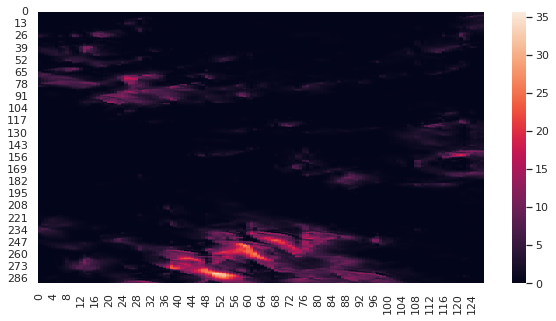

In [285]:
#####vmin=0, vmax=2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.figure(figsize=(10,5))
ax = sns.heatmap(inpp,vmin=0,vmax=np.max(target))
plt.show()

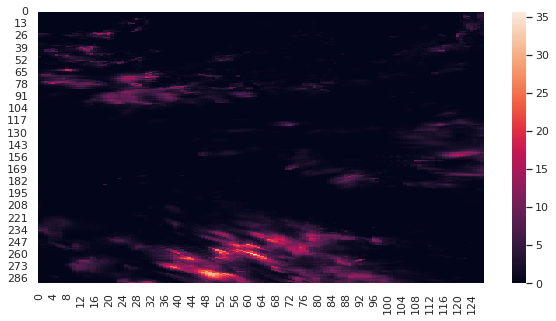

In [286]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.figure(figsize=(10,5))
ax = sns.heatmap(target,vmin=0,vmax=np.max(target))
plt.show()

In [287]:
filename

'20200801.nc4'

In [288]:
np.savetxt("20200801_target.txt", target)
np.savetxt("20200801_result.txt", inpp)
np.savetxt("20200801_errD.txt", errD)
np.savetxt("20200801_errG.txt", errG)

Random Seed:  8894
/content/SinGAN
Output/SR/4
1.2599210498948732 6
0.7937005259840997 0.7937005259840997
(1, 291, 128)
(291, 128)
torch.Size([291, 128])
torch.Size([1, 1, 73, 32])
torch.Size([1, 1, 73, 32])
torch.Size([1, 1, 42, 18]) 0
0.5625
torch.Size([1, 1, 46, 20]) 1
0.6191113591677425
torch.Size([1, 1, 50, 22]) 2
0.6814202223120523
torch.Size([1, 1, 55, 24]) 3
0.75
torch.Size([1, 1, 61, 27]) 4
0.8254818122236567
torch.Size([1, 1, 67, 30]) 5
0.9085602964160698
torch.Size([1, 1, 73, 32]) 6
1.0
GeneratorConcatSkip2CleanAdd(
  (head): ConvBlock(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (body): Sequential(
    (block1): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): Leak

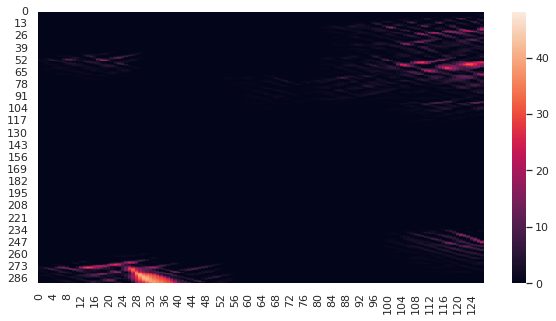

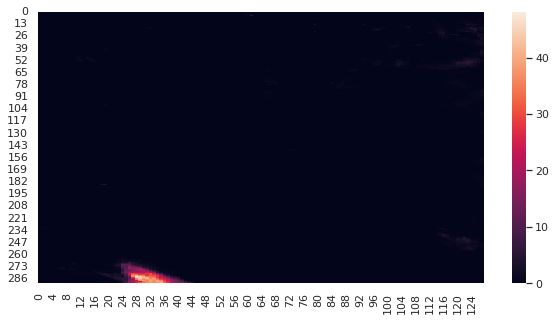

In [305]:
########
sys.argv = ['-f']
parser = get_arguments()
parser.add_argument('--input_dir', help='input image dir', default='Input/Images')
parser.add_argument('--input_name', help='training image name', default="20200925")#required=True)
parser.add_argument('--sr_factor', help='super resolution factor', type=float, default=4)
parser.add_argument('--mode', help='task to be done', default='SR')
sys.argv = ['-f']
parser.set_defaults(nc_im=1)
parser.set_defaults(nc_z=1)
parser.set_defaults(alpha=30)
parser.set_defaults(Gsteps=3)
opt = parser.parse_args()
opt = functions.post_config(opt)
opt
Gs = []
Zs = []
reals = []
NoiseAmp = []
dir2save = functions.generate_dir2save(opt)
dir2save
Gs = []
Zs = []
reals = []
NoiseAmp = []
%cd /content/SinGAN/
dir2save = mgenerate_dir2save(opt)
print(dir2save)
mode = opt.mode
mode
in_scale, iter_num = functions.calc_init_scale(opt)
print(in_scale, iter_num)
opt.scale_factor = 1 / in_scale
opt.scale_factor_init = 1 / in_scale
print(opt.scale_factor,opt.scale_factor_init)
opt.mode = 'train'
dir2trained_model = functions.generate_dir2save(opt)
from netCDF4 import Dataset as ncdataset
filename = '20200925.nc4'
dst = ncdataset(filename)
target=dst.variables['precipitationCal']
print(target.shape)
target=np.squeeze(target)
print(target.shape)
maxsd=[np.max(target)]
target_torch = torch.from_numpy(target)
target_torch = target_torch/np.max(target)
target_torch=norm(target_torch)
print(target_torch.shape)
target_torch=target_torch[None,None,:,:]
ud = mimresize(target_torch,1/4,maxsd,opt)
ud.shape
opt.min_size = 18
opt.max_size = 300
real = madjust_scales2image_SR(ud,maxsd,opt)
print(real.shape)
real_ = real
print(real_.shape)
reals = mcreat_reals_pyramid(real_,reals,maxsd,opt)
for i in range(0,opt.stop_scale+1,1):
  print(reals[i].shape,i)
  print(math.pow(opt.scale_factor,opt.stop_scale-i))
nfc_prev = 0
in_s = 0
scale_num = 0
errD=[]
errG=[]
while scale_num<opt.stop_scale+1:
        opt.nfc = min(opt.nfc_init * pow(2, math.floor(scale_num / 4)), 128)
        opt.min_nfc = min(opt.min_nfc_init * pow(2, math.floor(scale_num / 4)), 128)

        opt.out_ = mgenerate_dir2save(opt)
        opt.outf = '%s/%d' % (opt.out_,scale_num)
        try:
            os.makedirs(opt.outf)
        except OSError:
                pass

        #plt.imsave('%s/in.png' %  (opt.out_), functions.convert_image_np(real), vmin=0, vmax=1)
        #plt.imsave('%s/original.png' %  (opt.out_), functions.convert_image_np(real_), vmin=0, vmax=1)
        plt.imsave('%s/real_scale.png' %  (opt.outf), functions.convert_image_np(reals[scale_num]), vmin=0, vmax=1)

        D_curr,G_curr = init_models(opt)
        if (nfc_prev==opt.nfc):
            G_curr.load_state_dict(torch.load('%s/%d/netG.pth' % (opt.out_,scale_num-1)))
            D_curr.load_state_dict(torch.load('%s/%d/netD.pth' % (opt.out_,scale_num-1)))

        z_curr,in_s,G_curr,DS,GS = mtrain_single_scale(D_curr,G_curr,reals,Gs,Zs,in_s,NoiseAmp,opt)

        G_curr = functions.reset_grads(G_curr,False)
        G_curr.eval()
        D_curr = functions.reset_grads(D_curr,False)
        D_curr.eval()

        Gs.append(G_curr)
        Zs.append(z_curr)
        NoiseAmp.append(opt.noise_amp)
        errD.append(DS)
        errG.append(GS)

        torch.save(Zs, '%s/Zs.pth' % (opt.out_))
        torch.save(Gs, '%s/Gs.pth' % (opt.out_))
        torch.save(reals, '%s/reals.pth' % (opt.out_))
        torch.save(NoiseAmp, '%s/NoiseAmp.pth' % (opt.out_))

        scale_num+=1
        nfc_prev = opt.nfc
        del D_curr,G_curr
Zs_sr = []
reals_sr = []
NoiseAmp_sr = []
Gs_sr = []
real = reals[-1]  # read_image(opt)
real_ = real
opt.scale_factor = 1 / in_scale
opt.scale_factor_init = 1 / in_scale
print(real.shape)
print(opt.scale_factor,opt.scale_factor_init,iter_num)
for j in range(1, iter_num + 1, 1):
  real_ = mimresize(real_, pow(1 / opt.scale_factor, 1),maxsd,opt)
  reals_sr.append(real_)
  Gs_sr.append(Gs[-1])
  NoiseAmp_sr.append(NoiseAmp[-1])
  z_opt = torch.full(real_.shape, 0, device=opt.device)
  m = nn.ZeroPad2d(5)
  z_opt = m(z_opt)
  Zs_sr.append(z_opt)
for i in range(0,iter_num ):
  print(reals_sr[i].shape,i)  
opt.num_samples=1
out = mSinGAN_generate(Gs_sr, Zs_sr, reals_sr, NoiseAmp_sr, opt, in_s=reals_sr[0])
out = out[:, :, 0:int(opt.sr_factor * reals[-1].shape[2])-1, 0:int(opt.sr_factor * reals[-1].shape[3])]
print(out.shape,target.shape)
outt = denorm(out)
inp = outt[-1,-1,:,:].to(torch.device('cpu'))
inp =inp.numpy()
inpp = inp*maxsd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.figure(figsize=(10,5))
ax = sns.heatmap(inpp,vmin=0,vmax=np.max(target))
plt.show()
sns.set()
plt.figure(figsize=(10,5))
ax = sns.heatmap(target,vmin=0,vmax=np.max(target))
plt.show()
np.savetxt("20200925_target.txt", target)
np.savetxt("20200925_result.txt", inpp)
np.savetxt("20200925_errD.txt", errD)
np.savetxt("20200925_errG.txt", errG)

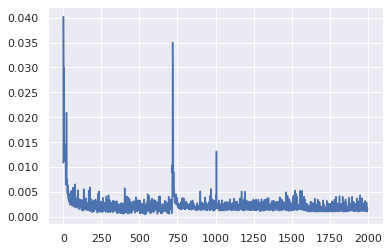

In [ ]:
plt.plot(n,errD[1])